In [11]:
# loading libraries needed to run initial file generation

import time
import numpy as np
import pandas as pd
import zarr
import os
import sys

import pylops
from pylops.utils.wavelets import ricker
%matplotlib notebook
import matplotlib . pyplot as plt

print('libraries loaded ')


libraries loaded 


In [12]:
##########################################################################
# parameters
#ZARR blob account - testing
AZURE_STORAGE_ACCOUNT_NAME="hugoblobtest12345"
AZURE_STORAGE_ACCESS_KEY="648X7ZKv2sdPFWbzUoBRWiu8igckisHM2mEYZtHD2zj/iBMWIhf8dGa4MQnAhbwu/peI9KB51HZd+ASt+Id1Iw=="
container_name="seismic"

backend='zarr_blob'
object_name1="ZarrVolume0"
'''
nsamples = 200;
nilines = 200;
nxlines = 150;
noffsets = 50;
nheaders = 9
'''
dt=0.004
dx=12.5
dh=100

print('done this cell')

done this cell


In [13]:
# function to build synthetic gather using pylops
def generate_synthetic_gather():
    par = {"ox": 0, "dx": dh, "nx": noffsets, "ot": 0, "dt": dt, "nt": nsamples, "f0": 30}

    # linear events
    v = 1500  # m/s
    t0 = [0.1*nsamples*dt,0.3*nsamples*dt,0.55*nsamples*dt,0.8*nsamples*dt]  # s
    theta = [0, 0, 0,0]
    amp = [1.0, -2, 0.5, 2]

    # parabolic event
    tp0 = [0.4*nsamples*dt]  # s
    px = [0]  # s/m
    pxx = [0.5e-8]  # sÂ²/mÂ²
    ampp = [1.5]
    
    # create axis
    taxis, taxis2, xaxis, yaxis = pylops.utils.seismicevents.makeaxis(par)
    
    # create wavelet
    wav = ricker(taxis[:41], f0=par["f0"])[0]

    # generate seismic model
    cig = (
        pylops.utils.seismicevents.linear2d(xaxis, taxis, v, t0, theta, amp, wav)[1]
        + pylops.utils.seismicevents.parabolic2d(xaxis, taxis, tp0, px, pxx, ampp, wav)[1]
    )
    cig = cig + (0.1-0.2*np.random.random((noffsets,nsamples)) )
    
    return cig


In [30]:
#read write fucntion
def task_to_be_done(il1,il2):

    il1 = int(il1)
    il2 = int(il2) + 1 
    for il in range(il1,il2):
        print('writing out inline',il)
        for xl in range(0,nxlines):
            #print('writing out xline',xl)
            izarr.volume[il,xl,:,:] = cig + (0.1-0.2*np.random.random((noffsets,nsamples)) )
            for o in range(0,noffsets):
                izarr.header[il,xl,o,0] = il
                izarr.header[il,xl,o,1] = xl
                izarr.header[il,xl,o,2] = o

    #time.sleep(10*random.random())             
    return il1,il2,noffsets


In [17]:
###########################################################################
# functions to measure time intervals
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " s")
    else:
        print("Toc: start time not set")

###########################################################################

In [18]:

#################################################################################
if backend == 'zarr':
    #synchronizer = zarr.ProcessSynchronizer(object_name1)
    synchronizer = zarr.ThreadSynchronizer()
    
    store = zarr.DirectoryStore(object_name1)
    root = zarr.group(store=store, overwrite=False)#,synchronizer=synchronizer)
    #vol = root.zeros('volume', chunks=chunk_v, shape=shape_v, compressor='none', dtype=np.float32)
    #hea = root.zeros('header', chunks=chunk_h,shape=shape_h, compressor='none', dtype=np.float32)

elif backend == 'zarr_blob':
    import azure.storage.blob
    #container_client = azure.storage.blob.ContainerClient(
    #    account_name=os.getenv("AZURE_STORAGE_ACCOUNT_NAME"),
    #    credential=os.getenv("AZURE_STORAGE_ACCESS_KEY"),
    #   account_url="https://{}.blob.core.windows.net".format(os.getenv("AZURE_STORAGE_ACCOUNT_NAME")),
    #  container_name=object_name1)
    container_client = azure.storage.blob.ContainerClient(
        account_name=AZURE_STORAGE_ACCOUNT_NAME,
        credential=AZURE_STORAGE_ACCESS_KEY,
        account_url="https://{}.blob.core.windows.net".format(AZURE_STORAGE_ACCOUNT_NAME),
        container_name=container_name)
    store = zarr.ABSStore(client=container_client, prefix=object_name1)
    root = zarr.group(store=store, overwrite=False)
    izarr=root

    #vol = root.zeros('volume', chunks=chunk_v, shape=shape_v, dtype=np.float32)
    #hea = root.zeros('header', chunks=chunk_h, shape=shape_h, dtype=np.float32)

nilines, nxlines,noffsets,nsamples = izarr.volume.shape
nilines, nxlines,noffsets,nheaders = izarr.header.shape
ntasks=nilines
print('nil=',nilines,' nxl=',nxlines,' noff=',noffsets,' ntasks=',ntasks)
 
###########################################################################
ntasks=nilines
print('nil=',nilines,' nxl=',nxlines,' noff=',noffsets,' ntasks=',ntasks)
 
# opening zarr output file
shape_v = (nilines,nxlines,noffsets,nsamples)
shape_h = (nilines,nxlines,noffsets,nheaders)

# parallel partition in inlines so need to chunk over this
chunk_v = (1,nxlines,noffsets,nsamples)
chunk_h = (1,nxlines,noffsets,nheaders)

cig = generate_synthetic_gather()
print('done this cell')

nil= 20  nxl= 15  noff= 50  ntasks= 20
nil= 20  nxl= 15  noff= 50  ntasks= 20
done this cell


In [32]:
#print('Number of arguments:', len(sys.argv), 'arguments.')
print('Argument List:', str(sys.argv) )

#nprocess = int(sys.argv[1])
#job_id = int(sys.argv[2])

nprocess = 4
job_id = 3

###########################################################################
# processsing gathers and writing out
print('processing seismic file of size ',shape_v)
print('writing out...')

i=job_id
il1 = np.floor(i*(nilines/nprocess)) 
il2 = np.floor((i+1)*(nilines/nprocess))-1
 
tic()
print("STARTING CALC")
print(il1,il2)
task_to_be_done(il1,il2)
toc()
print('done this cell')


Argument List: ['/venv/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/connection-spec']
processing seismic file of size  (20, 15, 50, 200)
writing out...
STARTING CALC
15.0 19.0
writing out inline 15
writing out inline 16
writing out inline 17
writing out inline 18
writing out inline 19
Elapsed time is 0.00011777877807617188 s
done this cell


opening zarr file
 printing figure
done this cell


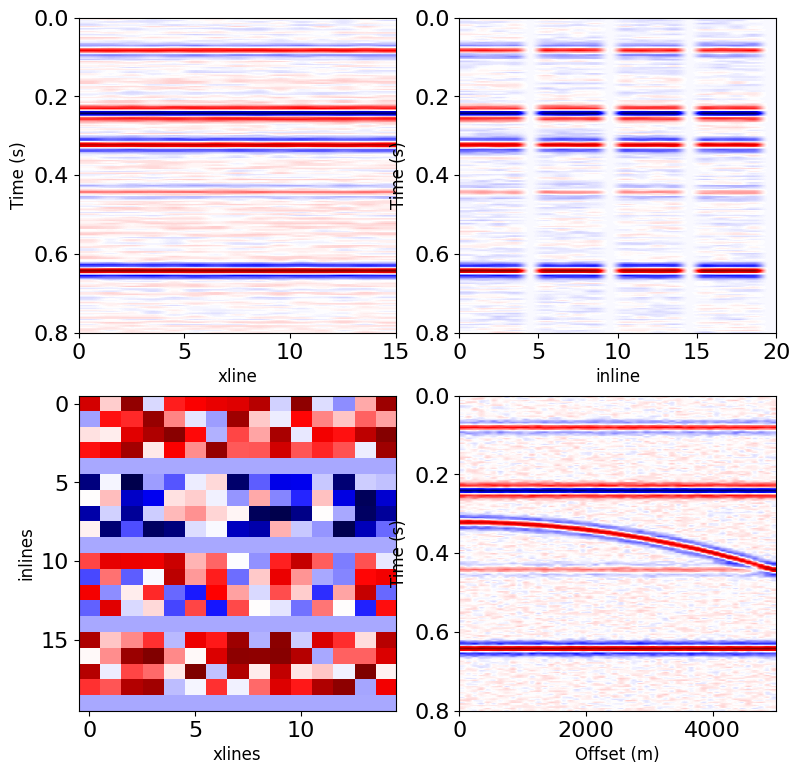

In [10]:
##########################################################################
# plot image for QC
figures_on=1
no=10
slx=int(nilines/2);
sly=int(nxlines/2)
slz=int(nsamples/2)
%matplotlib inline

if(figures_on==1):  
        # opening zarr input seismic file
        print('opening zarr file')
        if backend == 'zarr_blob':            
            container_client = azure.storage.blob.ContainerClient(
                account_name=AZURE_STORAGE_ACCOUNT_NAME,
                credential=AZURE_STORAGE_ACCESS_KEY,
                account_url="https://{}.blob.core.windows.net".format(AZURE_STORAGE_ACCOUNT_NAME),
                container_name=container_name)
            store = zarr.ABSStore(client=container_client, prefix=object_name1)
            root = zarr.group(store=store, overwrite=False)
            izarr=root
            # vol = root.zeros('volume', chunks=chunk_v, shape=shape_v, dtype=np.float32)
            # hea = root.zeros('header', chunks=chunk_h, shape=shape_h, dtype=np.float32)
        elif backend == 'zarr':
            print('opening input file to process',object_name1)
            izarr = zarr.open(object_name1, mode='r')
        
        print(' printing figure')
        fig = plt.figure(num=no,figsize=(9, 9)) ;
        vv = 0.02*np.max(izarr.volume[:,:,:,:]);
        plt.clf();
        
        
        mm = izarr.volume[slx,:,0,:]
        #print(mm)
        plt.subplot(221)
        plt.imshow(np.transpose(mm),cmap='seismic',extent=(0,nxlines,nsamples*dt,0))#,vmin=-vv,vmax=vv,cmap='seismic' );#, cmap="RdGy")
        #plt.colorbar();
        plt.gca().axis('tight')
        plt.ylabel('Time (s)',fontsize=12)
        plt.xlabel('xline',fontsize=12)
        #plt.gca().invert_yaxis()  
        
        mm = izarr.volume[:,sly,0,:]
        plt.subplot(222)
        plt.imshow(np.transpose(mm),extent=(0,nilines,nsamples*dt,0),cmap='seismic' );#, cmap="RdGy")
        #plt.colorbar();        
        plt.gca().axis('tight')
        plt.ylabel('Time (s)',fontsize=12)
        plt.xlabel('inline',fontsize=12)
        #plt.gca().invert_yaxis()
        
        mm=[];
        mm = izarr.volume[:,:,2,slz]
        plt.subplot(223)
        plt.imshow(mm,cmap='seismic');#, cmap="RdGy")
        #plt.gca().invert_yaxis()
        plt.gca().axis('tight')
        plt.ylabel('inlines',fontsize=12)
        plt.xlabel('xlines',fontsize=12)
        #plt.colorbar();

        mm=[];
        mm = izarr.volume[slx,sly,:,:]
        plt.subplot(224)
        plt.imshow(np.transpose(mm),cmap='seismic',extent=(0,noffsets*dh,nsamples*dt,0) )#,vmin=-vv,vmax=vv,cmap='seismic');#, cmap="RdGy")
        #plt.gca().invert_yaxis()
        plt.gca().axis('tight')
        plt.ylabel('Time (s)',fontsize=12)
        plt.xlabel('Offset (m)',fontsize=12)
        
###########################################################################
###########################################################################
print('done this cell')